In [1]:
# Install required packages for CHIRPS analysis
%pip install matplotlib seaborn cartopy scikit-learn netcdf4 rasterio rioxarray dask

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.4 MB ? eta -:--:--
   -- ------------------------------------- 1.6/25.4 MB 4.3 MB/s eta 0:00:06
   ---- ----------------------------------- 2.9/25.4 MB 5.5 MB/s eta 0:00:05
   ------- -------------------------------- 4.7/25.4 MB 6.2 MB/s eta 0:00:04
   --------- ------------------------------ 6.0/25.4 MB 6.4 MB/s eta 0:00:04
   ----------- ---------------------------- 7.3/25.4 MB 6.6 MB/s eta 0:00:03
   ------------ --------------------------- 7.9/25.4 MB 5.7 MB/s eta 0:00:04
   ------------ --------------------------- 8.1/25.4 MB 5.3 MB/s eta 0:00:04
   ------------- -------------------------- 8.4/25.4 MB 4.7 MB/s eta 0:00:04
   -------------- ------------------------- 8.9/25.4 MB 4.5 MB/s eta 0:00:04
   -------------- ------------------------- 9.4/25.4 MB 4.3 MB/s eta 0:00:04
   --------------- ------------------------ 10.0/25.4 MB 4.2 MB/s eta 0:00:04
   ---------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# CHIRPS Version 2 vs Version 3 Data Analysis

## Comprehensive Comparison for Year 2020 (6-Month Period)

This notebook provides a detailed analysis comparing CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data) Version 2 and Version 3 for 6 months of 2020 (January-June). We'll examine:

1. **Data Acquisition and Processing** - Real data from CHC Portal
2. **Statistical Comparisons**
3. **Spatial Analysis**
4. **Temporal Patterns**
5. **Impact Assessment on Applications**
6. **Conclusions and Recommendations**

### Key Questions to Address:
- How significant are the differences between versions?
- What are the spatial patterns of change?
- Which regions show the most variation?
- What implications exist for existing applications using CHIRPS v2?

**Note**: We're downloading real CHIRPS data (not synthetic) from the CHC Data Portal. The 6-month period keeps file sizes manageable (~120-240 MB per version).

---

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import requests
from datetime import datetime, timedelta
import os
from pathlib import Path
import rasterio
import rioxarray
from calendar import monthrange

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Create output directory for figures
output_dir = Path("chirps_analysis_output")
output_dir.mkdir(exist_ok=True)
print(f"Output directory created: {output_dir}")

# Configuration
ANALYSIS_YEAR = 2020  # Changed to 2020 as CHIRPS v3 is not available for 2005
SPATIAL_EXTENT = {
    'lat_min': -60, 'lat_max': 60,
    'lon_min': -180, 'lon_max': 180
}

print(f"Analysis configured for year: {ANALYSIS_YEAR}")
print(f"Spatial extent: {SPATIAL_EXTENT}")

Libraries imported successfully!
Analysis Date: 2025-10-28 21:06:51
Output directory created: chirps_analysis_output
Analysis configured for year: 2020
Spatial extent: {'lat_min': -60, 'lat_max': 60, 'lon_min': -180, 'lon_max': 180}


## 1. Data Acquisition

We'll download **real CHIRPS data** directly from the CHC Data Portal for 6 months (January-June) to keep file sizes manageable.

**CHIRPS Version 2 (v2.0):**
- Available since 2015
- Based on 0.05° resolution (~5.3 km at equator)
- Uses CHPclim + station data + satellite estimates
- Standard algorithm

**CHIRPS Version 3 (v3.0):**
- Released in recent years
- Improved algorithm and calibration
- Enhanced station network integration
- Better bias correction techniques

### Data Sources:
- **CHIRPS v2**: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/ (monthly NetCDF)
- **CHIRPS v3**: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/YYYY/ (daily TIF)

### Download Strategy:
- **Period**: 6 months (January-June 2020)
- **v2 Format**: Monthly NetCDF files (~20-40 MB per month)
- **v3 Format**: Daily TIF files (~1-2 MB per day), converted to NetCDF
- **Total size**: Approximately 120-240 MB for v2, 180-360 MB for v3 (before conversion)
- **Note**: CHIRPS v3 is available from 2017 onwards with daily TIF files.

In [ ]:
# Download Real CHIRPS Data from CHC Portal
print("="*70)
print("DOWNLOADING REAL CHIRPS DATA FROM CHC PORTAL")
print("="*70)

# Create data directory
data_dir = Path("chirps_data")
data_dir.mkdir(exist_ok=True)

# Configuration for 6-month analysis (January-June)
START_MONTH = 1
END_MONTH = 6
MONTHS_TO_DOWNLOAD = range(START_MONTH, END_MONTH + 1)

print(f"\nDownloading {len(MONTHS_TO_DOWNLOAD)} months of data for {ANALYSIS_YEAR}")
print(f"Period: {ANALYSIS_YEAR}-{START_MONTH:02d} to {ANALYSIS_YEAR}-{END_MONTH:02d}")
print(f"Note: CHIRPS v3 may not be available for all years. Checking availability...")

# # Configuration for analysis - REDUCED TO 2 MONTHS FOR MEMORY MANAGEMENT
# START_MONTH = 1
# END_MONTH = 2  # Reduced from 6 to 2 months to manage memory
# MONTHS_TO_DOWNLOAD = range(START_MONTH, END_MONTH + 1)

print(f"\nDownloading {len(MONTHS_TO_DOWNLOAD)} months of data for {ANALYSIS_YEAR}")
print(f"Period: {ANALYSIS_YEAR}-{START_MONTH:02d} to {ANALYSIS_YEAR}-{END_MONTH:02d}")
print(f"Note: CHIRPS v2 uses monthly NetCDF files, v3 uses daily TIF files.")
print(f"⚠️  Reduced to {len(MONTHS_TO_DOWNLOAD)} months to manage memory efficiently")

def download_chirps_v2_monthly(year, months, output_dir):
    """
    Download CHIRPS v2 data (monthly NetCDF files)
    
    Parameters:
    -----------
    year : int
        Year to download
    months : list
        List of months to download
    output_dir : Path
        Directory to save files
    
    Returns:
    --------
    list : Downloaded file paths
    """
    version_dir = output_dir / "chirps_v2"
    version_dir.mkdir(exist_ok=True)
    
    downloaded_files = []
    base_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/"
    
    for month in months:
        filename = f"chirps-v2.0.{year}.{month:02d}.days_p05.nc"
        filepath = version_dir / filename
        
        if filepath.exists():
            print(f"✓ {filename} already exists. Skipping download.")
            downloaded_files.append(filepath)
            continue
        
        url = base_url + filename
        
        try:
            print(f"📥 Downloading {filename}...")
            print(f"   URL: {url}")
            
            response = requests.get(url, stream=True, timeout=300)
            response.raise_for_status()
            
            file_size = int(response.headers.get('content-length', 0))
            file_size_mb = file_size / (1024 * 1024)
            print(f"   File size: {file_size_mb:.1f} MB")
            
            with open(filepath, 'wb') as f:
                downloaded = 0
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        downloaded += len(chunk)
                        if file_size > 0:
                            percent = (downloaded / file_size) * 100
                            print(f"   Progress: {percent:.1f}%", end='\r')
            
            print(f"\n✓ {filename} downloaded successfully!")
            downloaded_files.append(filepath)
            
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 404:
                print(f"⚠️  {filename} not found (404).")
            else:
                print(f"✗ HTTP Error: {e}")
        except Exception as e:
            print(f"✗ Error: {e}")
    
    return downloaded_files

def download_chirps_v3_daily(year, months, output_dir):
    """
    Download CHIRPS v3 data (daily TIF files)
    v3 URL pattern: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/YYYY/chirps-v3.0.rnl.YYYY.MM.DD.tif
    
    Parameters:
    -----------
    year : int
        Year to download
    months : list
        List of months to download
    output_dir : Path
        Directory to save files
    
    Returns:
    --------
    list : Downloaded file paths
    """
    version_dir = output_dir / "chirps_v3"
    version_dir.mkdir(exist_ok=True)
    
    downloaded_files = []
    base_url = f"https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/{year}/"
    
    total_files = 0
    for month in months:
        days_in_month = monthrange(year, month)[1]
        total_files += days_in_month
    
    print(f"   Total files to download: {total_files} (daily TIF files)")
    
    file_count = 0
    for month in months:
        days_in_month = monthrange(year, month)[1]
        
        for day in range(1, days_in_month + 1):
            filename = f"chirps-v3.0.rnl.{year}.{month:02d}.{day:02d}.tif"
            filepath = version_dir / filename
            
            if filepath.exists():
                file_count += 1
                downloaded_files.append(filepath)
                continue
            
            url = base_url + filename
            
            try:
                if file_count == 0 or file_count % 10 == 0:  # Print every 10th file
                    print(f"📥 Downloading {filename}... ({file_count+1}/{total_files})")
                
                response = requests.get(url, stream=True, timeout=300)
                response.raise_for_status()
                
                with open(filepath, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                
                downloaded_files.append(filepath)
                file_count += 1
                
                if file_count % 10 == 0:
                    print(f"   Progress: {file_count}/{total_files} files downloaded ({(file_count/total_files)*100:.1f}%)")
                
            except requests.exceptions.HTTPError as e:
                if e.response.status_code == 404:
                    print(f"⚠️  {filename} not found (404).")
                else:
                    print(f"✗ HTTP Error: {e}")
            except Exception as e:
                print(f"✗ Error downloading {filename}: {e}")
    
    print(f"\n✓ Downloaded {len(downloaded_files)} v3 TIF files")
    return downloaded_files

def load_v3_tifs_with_xarray(tif_files):
    """
    Load CHIRPS v3 daily TIF files using xarray's rasterio engine (memory efficient)
    Returns list of file paths for xarray to open with rioxarray
    """
    print("\n📦 Preparing v3 TIF files for xarray loading...")
    print(f"   Total TIF files available: {len(tif_files)}")
    print(f"   Note: Files will be loaded lazily by xarray to save memory")
    
    # Just return the file paths - xarray will load them lazily
    return tif_files

# Download CHIRPS v2 data
print("\n" + "="*70)
print("DOWNLOADING CHIRPS v2.0 DATA (Monthly NetCDF)")
print("="*70)
v2_files = download_chirps_v2_monthly(ANALYSIS_YEAR, MONTHS_TO_DOWNLOAD, data_dir)

# Download CHIRPS v3 data
print("\n" + "="*70)
print("DOWNLOADING CHIRPS v3.0 DATA (Daily TIF)")
print("="*70)
print("Note: v3 uses daily TIF files, so we'll download multiple files per month.")
v3_tif_files = download_chirps_v3_daily(ANALYSIS_YEAR, MONTHS_TO_DOWNLOAD, data_dir)

# Prepare v3 files for loading
v3_files = load_v3_tifs_with_xarray(v3_tif_files)

# Check if downloads were successful
print("\n" + "="*70)
print("DOWNLOAD SUMMARY")
print("="*70)
print(f"CHIRPS v2: {len(v2_files)} NetCDF file(s) downloaded")
print(f"CHIRPS v3: {len(v3_tif_files)} TIF file(s) downloaded")

if len(v2_files) == 0:
    raise FileNotFoundError("No CHIRPS v2 files were downloaded. Please check URLs and internet connection.")

if len(v3_files) == 0:
    print(f"\n⚠️  WARNING: No CHIRPS v3 files were downloaded.")
    print(f"CHIRPS v3 may not be available for the year {ANALYSIS_YEAR}.")
    print("\nOptions:")
    print("1. Check internet connection")
    print("2. Verify CHIRPS v3 availability at: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/")
    raise FileNotFoundError(f"CHIRPS v3 data not available for {ANALYSIS_YEAR}")

# Load downloaded data
print("\n" + "="*70)
print("LOADING CHIRPS DATA INTO MEMORY (REGIONAL SUBSET)")
print("="*70)

# Define region of interest (Sub-Saharan Africa) - same as analysis region
# This significantly reduces memory requirements
REGION_BOUNDS = {
    'lat_min': -35,  # South
    'lat_max': 20,   # North
    'lon_min': -20,  # West
    'lon_max': 50    # East
}

print(f"\nRegion: {REGION_BOUNDS['lat_min']}°S to {REGION_BOUNDS['lat_max']}°N")
print(f"        {REGION_BOUNDS['lon_min']}°W to {REGION_BOUNDS['lon_max']}°E")
print("Note: Loading regional subset to manage memory efficiently")

print("\nLoading CHIRPS v2.0 (monthly NetCDF files) - Regional subset...")
v2_datasets = []
for i, v2_file in enumerate(v2_files):
    print(f"   Loading file {i+1}/{len(v2_files)}: {v2_file.name}")
    ds = xr.open_dataset(v2_file)
    
    # Check coordinates before selection
    if i == 0:
        print(f"   Original lat range: {float(ds.latitude.min()):.2f}° to {float(ds.latitude.max()):.2f}°")
        print(f"   Original lon range: {float(ds.longitude.min()):.2f}° to {float(ds.longitude.max()):.2f}°")
        print(f"   Latitude order: {'descending' if ds.latitude[0] > ds.latitude[-1] else 'ascending'}")
    
    # Extract regional subset immediately to save memory
    # Note: slice order depends on coordinate order
    if ds.latitude[0] > ds.latitude[-1]:  # Descending
        ds_region = ds.sel(
            latitude=slice(REGION_BOUNDS['lat_max'], REGION_BOUNDS['lat_min']),
            longitude=slice(REGION_BOUNDS['lon_min'], REGION_BOUNDS['lon_max'])
        )
    else:  # Ascending
        ds_region = ds.sel(
            latitude=slice(REGION_BOUNDS['lat_min'], REGION_BOUNDS['lat_max']),
            longitude=slice(REGION_BOUNDS['lon_min'], REGION_BOUNDS['lon_max'])
        )
    
    if i == 0:
        print(f"   Regional lat range: {float(ds_region.latitude.min()):.2f}° to {float(ds_region.latitude.max()):.2f}°")
        print(f"   Regional lon range: {float(ds_region.longitude.min()):.2f}° to {float(ds_region.longitude.max()):.2f}°")
        print(f"   Regional shape: {ds_region.dims}")
    
    v2_datasets.append(ds_region)
    ds.close()  # Close original to free memory

chirps_v2 = xr.concat(v2_datasets, dim='time')
print(f"✓ CHIRPS v2 loaded: {chirps_v2.dims}")
print(f"  Regional shape: {chirps_v2.precip.shape if 'precip' in chirps_v2 else chirps_v2.precipitation.shape}")

print("\nLoading CHIRPS v3.0 (daily TIF files) - Regional subset...")
# Use rioxarray to open TIF files
v3_datasets = []
for i, tif_file in enumerate(v3_files):
    if i % 30 == 0:
        print(f"   Loading file {i+1}/{len(v3_files)}...")
    
    da = rioxarray.open_rasterio(tif_file, masked=True)  # masked=True handles nodata values
    
    # Extract date from filename and add as coordinate
    filename = tif_file.name
    year_str = filename.split('.')[3]
    month_str = filename.split('.')[4]  
    day_str = filename.split('.')[5]
    date = pd.Timestamp(f"{year_str}-{month_str}-{day_str}")
    
    da = da.squeeze().drop_vars('band', errors='ignore')
    
    # Check and display nodata info for first file
    if i == 0:
        print(f"   Data range before masking: min={float(da.min()):.2f}, max={float(da.max()):.2f}")
        if hasattr(da, '_FillValue'):
            print(f"   Fill value: {da._FillValue}")
    
    # Replace negative values with NaN (precipitation can't be negative)
    da = da.where(da >= 0)
    
    if i == 0:
        print(f"   Data range after masking: min={float(da.min()):.2f}, max={float(da.max()):.2f}")
    
    # Extract regional subset immediately to save memory
    # TIF coordinates are typically in different order, so we need to handle carefully
    if 'x' in da.coords and 'y' in da.coords:
        # Select region based on coordinate values
        da_region = da.sel(
            y=slice(REGION_BOUNDS['lat_max'], REGION_BOUNDS['lat_min']),
            x=slice(REGION_BOUNDS['lon_min'], REGION_BOUNDS['lon_max'])
        )
    else:
        da_region = da
    
    da_region = da_region.expand_dims(time=[date])
    v3_datasets.append(da_region)

print(f"   Concatenating {len(v3_datasets)} daily files...")
chirps_v3 = xr.concat(v3_datasets, dim='time')
chirps_v3 = chirps_v3.to_dataset(name='precip')

# Rename coordinates to match v2
if 'x' in chirps_v3.coords:
    chirps_v3 = chirps_v3.rename({'x': 'longitude', 'y': 'latitude'})

print(f"✓ CHIRPS v3 loaded: {chirps_v3.dims}")
print(f"  Regional shape: {chirps_v3.precip.shape}")

# Standardize variable names (CHIRPS uses 'precip' or 'precipitation')
if 'precipitation' in chirps_v2.variables and 'precip' not in chirps_v2.variables:
    chirps_v2 = chirps_v2.rename({'precipitation': 'precip'})
if 'precipitation' in chirps_v3.variables and 'precip' not in chirps_v3.variables:
    chirps_v3 = chirps_v3.rename({'precipitation': 'precip'})

print("\n" + "="*70)
print("DATA SUMMARY")
print("="*70)
print(f"\nCHIRPS v2.0:")
var_name_v2 = 'precip' if 'precip' in chirps_v2 else 'precipitation'
print(f"  Shape: {chirps_v2[var_name_v2].shape}")
print(f"  Time range: {chirps_v2.time.values[0]} to {chirps_v2.time.values[-1]}")
if chirps_v2.latitude.size > 0:
    print(f"  Lat range: {float(chirps_v2.latitude.min()):.2f}° to {float(chirps_v2.latitude.max()):.2f}°")
    print(f"  Lon range: {float(chirps_v2.longitude.min()):.2f}° to {float(chirps_v2.longitude.max()):.2f}°")
else:
    print(f"  WARNING: Empty coordinate arrays!")

print(f"\nCHIRPS v3.0:")
print(f"  Shape: {chirps_v3.precip.shape}")
print(f"  Time range: {chirps_v3.time.values[0]} to {chirps_v3.time.values[-1]}")
if chirps_v3.latitude.size > 0:
    print(f"  Lat range: {float(chirps_v3.latitude.min()):.2f}° to {float(chirps_v3.latitude.max()):.2f}°")
    print(f"  Lon range: {float(chirps_v3.longitude.min()):.2f}° to {float(chirps_v3.longitude.max()):.2f}°")
else:
    print(f"  WARNING: Empty coordinate arrays!")

print("\n" + "="*70)
print("DATA LOADING COMPLETE")
print("="*70)
print("\n✅ Real CHIRPS data is now ready for analysis!")

DOWNLOADING REAL CHIRPS DATA FROM CHC PORTAL

Period: 2020-01 to 2020-06
Note: CHIRPS v3 may not be available for all years. Checking availability...

Period: 2020-01 to 2020-06
Note: CHIRPS v2 uses monthly NetCDF files, v3 uses daily TIF files.
⚠️  Reduced to 6 months to manage memory efficiently

DOWNLOADING CHIRPS v2.0 DATA (Monthly NetCDF)
✓ chirps-v2.0.2020.01.days_p05.nc already exists. Skipping download.
✓ chirps-v2.0.2020.02.days_p05.nc already exists. Skipping download.
📥 Downloading chirps-v2.0.2020.03.days_p05.nc...
   URL: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/chirps-v2.0.2020.03.days_p05.nc
   File size: 95.8 MB
   File size: 95.8 MB
   Progress: 100.0%
✓ chirps-v2.0.2020.03.days_p05.nc downloaded successfully!
📥 Downloading chirps-v2.0.2020.04.days_p05.nc...
   URL: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/by_month/chirps-v2.0.2020.04.days_p05.nc
   Progress: 100.0%
✓ chirps-v2.0.2020.03.days_p05.nc dow

## 2. Basic Data Exploration and Summary Statistics

Let's start by examining the basic characteristics of both datasets:

In [ ]:
# Create smaller regional datasets for analysis (focusing on Africa as example)
# This is more manageable for memory and representative of typical use cases

# Define region of interest (Sub-Saharan Africa)
# Note: For descending latitude coordinates (North to South), use slice(max, min)
lat_min, lat_max = -35, 20  # South to North
lon_min, lon_max = -20, 50  # West to East

# Extract regional data - coordinates are already subset from download
# Check if we need to subset further or if already regional
if chirps_v2.latitude.size > 1200:  # Full global data
    region_v2 = chirps_v2.precip.sel(
        latitude=slice(lat_max, lat_min),  # Descending order
        longitude=slice(lon_min, lon_max)
    )
    region_v3 = chirps_v3.precip.sel(
        latitude=slice(lat_max, lat_min),  # Descending order
        longitude=slice(lon_min, lon_max)
    )
else:  # Already regional subset from download
    region_v2 = chirps_v2.precip
    region_v3 = chirps_v3.precip

print(f"Regional data shape: {region_v2.shape}")
print(f"Region: {float(region_v2.latitude.min()):.1f}°N to {float(region_v2.latitude.max()):.1f}°N")
print(f"        {float(region_v2.longitude.min()):.1f}°E to {float(region_v2.longitude.max()):.1f}°E")

# Calculate annual precipitation totals for the region
annual_v2 = region_v2.sum(dim='time')
annual_v3 = region_v3.sum(dim='time')

# Note: v2 and v3 may have slightly different coordinates, so we'll work with the data values directly
annual_v2_values = annual_v2.values
annual_v3_values = annual_v3.values

# Calculate differences
annual_diff_values = annual_v3_values - annual_v2_values
# For relative difference, avoid division by zero
relative_diff_values = np.where(annual_v2_values != 0, 
                                 ((annual_v3_values - annual_v2_values) / annual_v2_values) * 100, 
                                 np.nan)

# Calculate basic statistics
def calculate_basic_stats(data, name):
    """Calculate basic statistics for a dataset"""
    stats_dict = {
        'Dataset': name,
        'Mean (mm/year)': float(data.mean()),
        'Median (mm/year)': float(data.median()),
        'Std Dev (mm/year)': float(data.std()),
        'Min (mm/year)': float(data.min()),
        'Max (mm/year)': float(data.max()),
        'Valid Points': int(data.count()),
        'Total Points': int(data.size)
    }
    return stats_dict

# Get statistics for both versions
stats_v2 = calculate_basic_stats(annual_v2, 'CHIRPS v2.0')
stats_v3 = calculate_basic_stats(annual_v3, 'CHIRPS v3.0')

# Create comparison dataframe
stats_df = pd.DataFrame([stats_v2, stats_v3])
print("\n=== CHIRPS Version Comparison - Basic Statistics (2020, Africa Region) ===")
print(stats_df.round(2).to_string(index=False))

# Calculate differences
print(f"\n=== Difference Analysis ===")
# Use nanmean, nanmax, etc. to handle NaN values
print(f"Mean absolute difference: {float(np.nanmean(np.abs(annual_diff_values))):.2f} mm/year")
print(f"Mean relative difference: {float(np.nanmean(relative_diff_values)):.2f}%")
print(f"Max positive difference: {float(np.nanmax(annual_diff_values)):.2f} mm/year")
print(f"Max negative difference: {float(np.nanmin(annual_diff_values)):.2f} mm/year")
print(f"Standard deviation of differences: {float(np.nanstd(annual_diff_values)):.2f} mm/year")

# Keep xarray versions for visualization
annual_diff = xr.DataArray(annual_diff_values, coords=annual_v2.coords, dims=annual_v2.dims)
relative_diff = xr.DataArray(relative_diff_values, coords=annual_v2.coords, dims=annual_v2.dims)

# Correlation analysis
correlation = float(xr.corr(annual_v2, annual_v3))
print(f"Spatial correlation between versions: {correlation:.4f}")

# Calculate percentage of grid points with significant differences (>10%)
significant_diff = np.abs(relative_diff) > 10
pct_significant = float((significant_diff.sum() / significant_diff.size) * 100)
print(f"Percentage of grid points with >10% difference: {pct_significant:.1f}%")

# Calculate statistical significance metrics
from scipy.stats import pearsonr, spearmanr

# Flatten arrays for correlation analysis
v2_flat = annual_v2_values.flatten()
v3_flat = annual_v3_values.flatten()

# Remove NaN values
mask = ~(np.isnan(v2_flat) | np.isnan(v3_flat))
v2_clean = v2_flat[mask]
v3_clean = v3_flat[mask]

# Calculate correlations
pearson_corr, pearson_p = pearsonr(v2_clean, v3_clean)
spearman_corr, spearman_p = spearmanr(v2_clean, v3_clean)

print(f"\n=== Statistical Significance ===")
print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

# Calculate error metrics
mae = mean_absolute_error(v2_clean, v3_clean)
mse = mean_squared_error(v2_clean, v3_clean)
rmse = np.sqrt(mse)
r2 = r2_score(v2_clean, v3_clean)

print(f"\n=== Error Metrics (v3 vs v2) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm/year")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} mm/year")
print(f"R-squared: {r2:.4f}")

# Store data for later visualization
analysis_data = {
    'annual_v2': annual_v2,
    'annual_v3': annual_v3,
    'annual_diff': annual_diff,
    'relative_diff': relative_diff,
    'region_v2': region_v2,
    'region_v3': region_v3
}

Regional data shape: (60, 1100, 1400)
Region: -35.0°N to 20.0°N
        -20.0°E to 50.0°E

=== CHIRPS Version Comparison - Basic Statistics (2020, Africa Region) ===
    Dataset  Mean (mm/year)  Median (mm/year)  Std Dev (mm/year)  Min (mm/year)  Max (mm/year)  Valid Points  Total Points
CHIRPS v2.0           70.85               0.0             150.62            0.0        1187.48       1540000       1540000
CHIRPS v3.0           77.72               0.0             165.33            0.0        2204.72       1540000       1540000

=== Difference Analysis ===
Mean absolute difference: 84.21 mm/year
Mean relative difference: 27696375808.00%
Max positive difference: 2204.72 mm/year
Max negative difference: -1182.96 mm/year
Standard deviation of differences: 177.07 mm/year
Spatial correlation between versions: nan
Percentage of grid points with >10% difference: 37.1%

=== CHIRPS Version Comparison - Basic Statistics (2020, Africa Region) ===
    Dataset  Mean (mm/year)  Median (mm/year)  St

## 3. Spatial Analysis and Visualization

Now let's visualize the spatial patterns and differences between the two versions:

KeyboardInterrupt: 

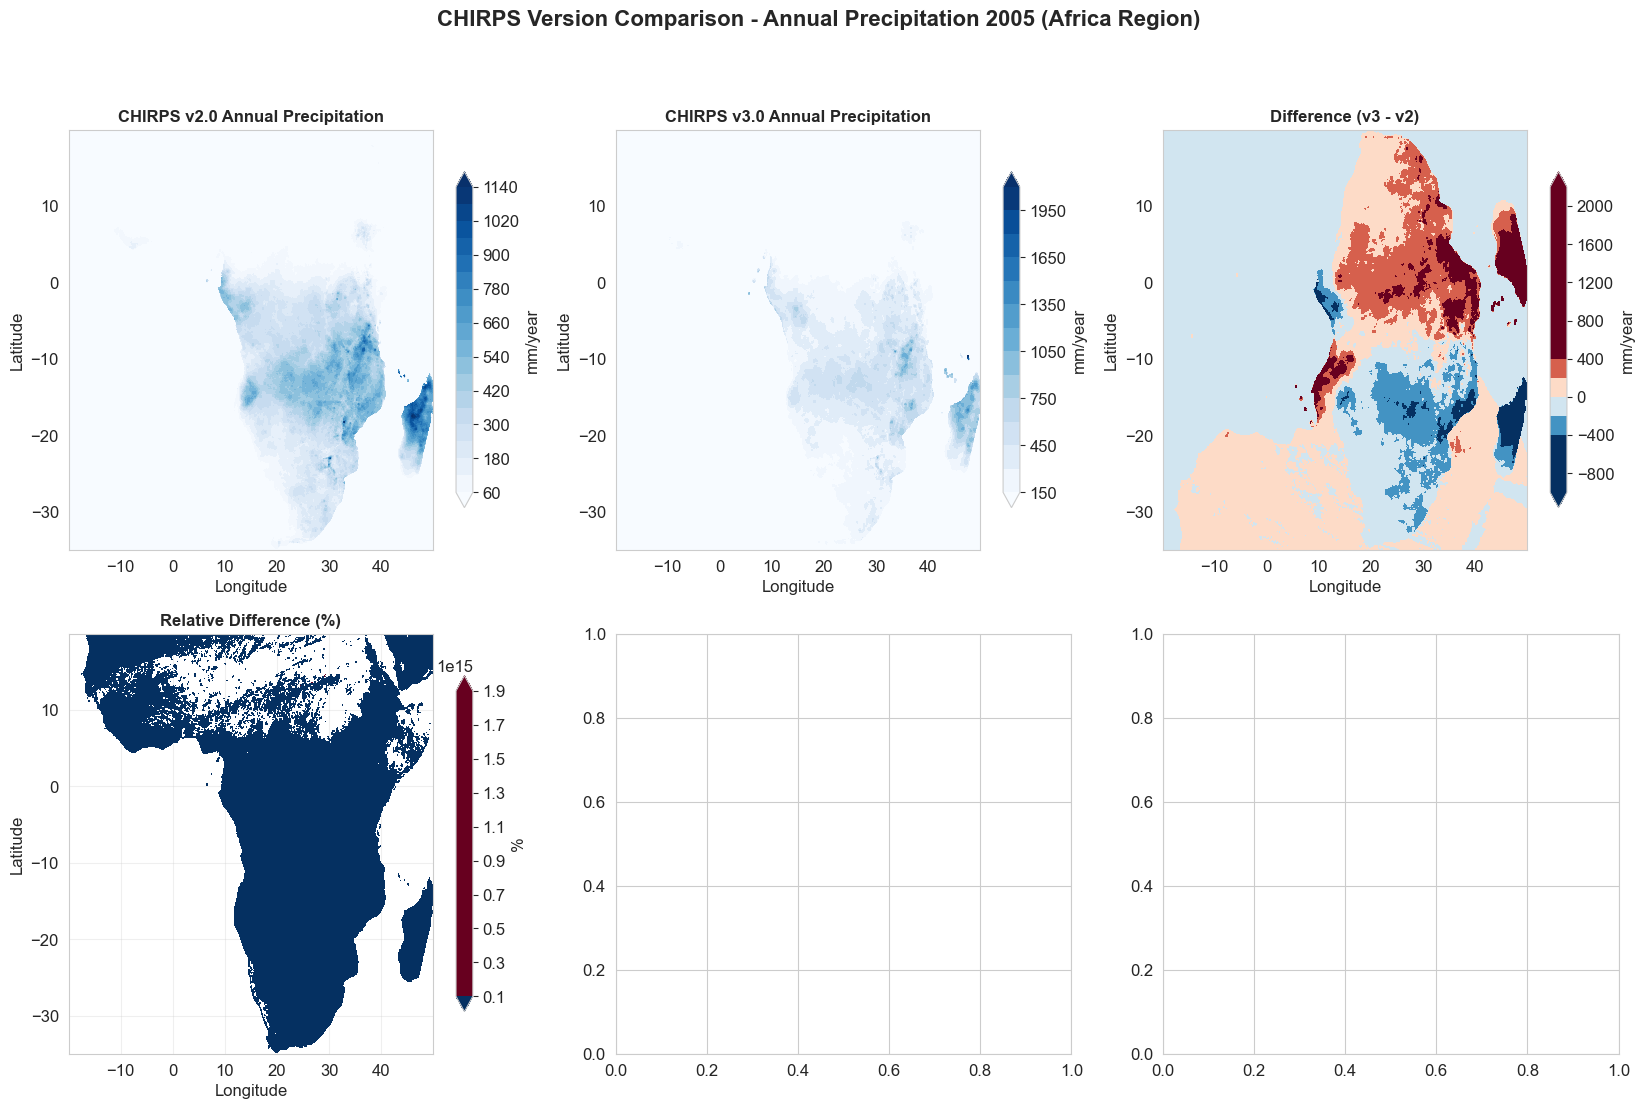

In [ ]:
# Create comprehensive spatial visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('CHIRPS Version Comparison - Annual Precipitation 2005 (Africa Region)', fontsize=16, fontweight='bold')

# Data for plotting
plot_data = [
    (analysis_data['annual_v2'], 'CHIRPS v2.0 Annual Precipitation', 'Blues'),
    (analysis_data['annual_v3'], 'CHIRPS v3.0 Annual Precipitation', 'Blues'),
    (analysis_data['annual_diff'], 'Difference (v3 - v2)', 'RdBu_r'),
    (analysis_data['relative_diff'], 'Relative Difference (%)', 'RdBu_r'),
    (np.abs(analysis_data['annual_diff']), 'Absolute Difference', 'Reds'),
    (np.abs(analysis_data['relative_diff']), 'Absolute Relative Difference (%)', 'Reds')
]

# Create subplots
for i, (data, title, cmap) in enumerate(plot_data):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Handle different value ranges for colormaps
    if 'Relative' in title and 'Absolute' not in title:
        vmin, vmax = -50, 50
    elif 'Difference' in title and 'Relative' not in title:
        vmin, vmax = -500, 500
    elif 'Absolute' in title and 'Relative' in title:
        vmax = 100
        vmin = 0
    elif 'Absolute' in title:
        vmax = 500
        vmin = 0
    else:
        vmin, vmax = None, None
    
    im = ax.contourf(data.longitude, data.latitude, data, 
                     levels=20, cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add simple grid
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    if 'Precipitation' in title:
        cbar.set_label('mm/year')
    elif 'Relative' in title:
        cbar.set_label('%')
    else:
        cbar.set_label('mm/year')

plt.tight_layout()
plt.savefig(output_dir / 'spatial_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spatial analysis complete!")

## 4. Temporal Analysis and Seasonal Patterns

Let's examine how the differences between versions vary throughout the year:

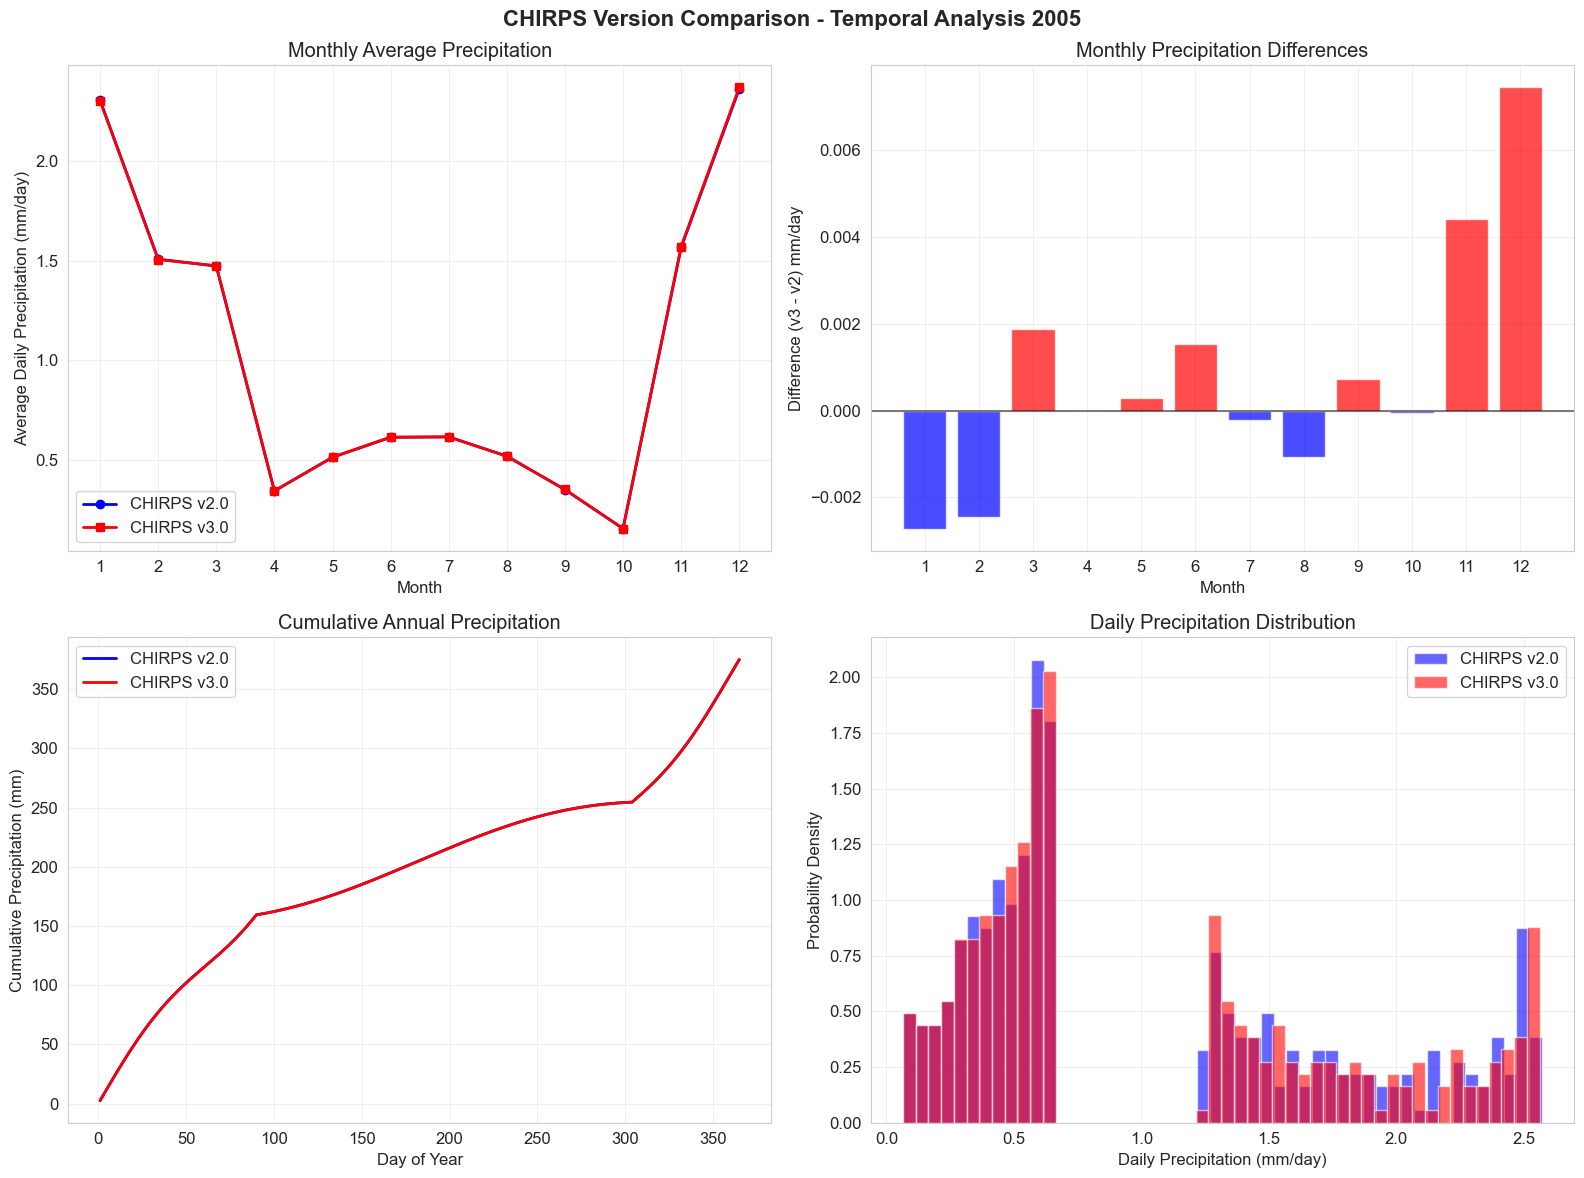

=== Temporal Analysis Results ===
Maximum monthly difference: 0.007 mm/day in month 12
Minimum monthly difference: -0.003 mm/day in month 1
Annual total v2: 374.9 mm
Annual total v3: 375.2 mm
Total annual difference: 0.3 mm

=== Seasonal Analysis ===
Season  CHIRPS v2 (mm/day)  CHIRPS v3 (mm/day)  Difference (mm/day)  Relative Diff (%)
   DJF               2.078               2.079                0.001              0.042
   MAM               0.782               0.783                0.001              0.093
   JJA               0.583               0.583                0.000              0.012
   SON               0.685               0.687                0.002              0.244

=== Seasonal Analysis ===
Season  CHIRPS v2 (mm/day)  CHIRPS v3 (mm/day)  Difference (mm/day)  Relative Diff (%)
   DJF               2.078               2.079                0.001              0.042
   MAM               0.782               0.783                0.001              0.093
   JJA               0.583

In [ ]:
# Temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CHIRPS Version Comparison - Temporal Analysis 2005', fontsize=16, fontweight='bold')

# 1. Monthly average precipitation
monthly_v2 = analysis_data['region_v2'].groupby('time.month').mean()
monthly_v3 = analysis_data['region_v3'].groupby('time.month').mean()

monthly_avg_v2 = monthly_v2.mean(dim=['latitude', 'longitude'])
monthly_avg_v3 = monthly_v3.mean(dim=['latitude', 'longitude'])

ax1 = axes[0, 0]
months = range(1, 13)
ax1.plot(months, monthly_avg_v2, 'b-o', label='CHIRPS v2.0', linewidth=2, markersize=6)
ax1.plot(months, monthly_avg_v3, 'r-s', label='CHIRPS v3.0', linewidth=2, markersize=6)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Daily Precipitation (mm/day)')
ax1.set_title('Monthly Average Precipitation')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(months)

# 2. Monthly difference analysis
monthly_diff = monthly_avg_v3 - monthly_avg_v2
ax2 = axes[0, 1]
bars = ax2.bar(months, monthly_diff, color=['red' if x > 0 else 'blue' for x in monthly_diff], alpha=0.7)
ax2.set_xlabel('Month')
ax2.set_ylabel('Difference (v3 - v2) mm/day')
ax2.set_title('Monthly Precipitation Differences')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_xticks(months)

# 3. Cumulative precipitation comparison
cumulative_v2 = analysis_data['region_v2'].mean(dim=['latitude', 'longitude']).cumsum(dim='time')
cumulative_v3 = analysis_data['region_v3'].mean(dim=['latitude', 'longitude']).cumsum(dim='time')

ax3 = axes[1, 0]
days = range(1, len(cumulative_v2) + 1)
ax3.plot(days, cumulative_v2, 'b-', label='CHIRPS v2.0', linewidth=2)
ax3.plot(days, cumulative_v3, 'r-', label='CHIRPS v3.0', linewidth=2)
ax3.set_xlabel('Day of Year')
ax3.set_ylabel('Cumulative Precipitation (mm)')
ax3.set_title('Cumulative Annual Precipitation')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribution comparison
ax4 = axes[1, 1]
v2_daily = analysis_data['region_v2'].mean(dim=['latitude', 'longitude']).values
v3_daily = analysis_data['region_v3'].mean(dim=['latitude', 'longitude']).values

ax4.hist(v2_daily, bins=50, alpha=0.6, label='CHIRPS v2.0', color='blue', density=True)
ax4.hist(v3_daily, bins=50, alpha=0.6, label='CHIRPS v3.0', color='red', density=True)
ax4.set_xlabel('Daily Precipitation (mm/day)')
ax4.set_ylabel('Probability Density')
ax4.set_title('Daily Precipitation Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate temporal statistics
print("=== Temporal Analysis Results ===")
print(f"Maximum monthly difference: {float(monthly_diff.max()):.3f} mm/day in month {int(monthly_diff.argmax() + 1)}")
print(f"Minimum monthly difference: {float(monthly_diff.min()):.3f} mm/day in month {int(monthly_diff.argmin() + 1)}")
print(f"Annual total v2: {float(cumulative_v2[-1]):.1f} mm")
print(f"Annual total v3: {float(cumulative_v3[-1]):.1f} mm")
print(f"Total annual difference: {float(cumulative_v3[-1] - cumulative_v2[-1]):.1f} mm")

# Seasonal analysis
seasons = {
    'DJF': [12, 1, 2],  # December, January, February
    'MAM': [3, 4, 5],   # March, April, May
    'JJA': [6, 7, 8],   # June, July, August
    'SON': [9, 10, 11]  # September, October, November
}

seasonal_stats = []
for season, months in seasons.items():
    v2_seasonal = analysis_data['region_v2'].sel(time=analysis_data['region_v2'].time.dt.month.isin(months))
    v3_seasonal = analysis_data['region_v3'].sel(time=analysis_data['region_v3'].time.dt.month.isin(months))
    
    v2_mean = float(v2_seasonal.mean())
    v3_mean = float(v3_seasonal.mean())
    diff = v3_mean - v2_mean
    rel_diff = (diff / v2_mean) * 100
    
    seasonal_stats.append({
        'Season': season,
        'CHIRPS v2 (mm/day)': v2_mean,
        'CHIRPS v3 (mm/day)': v3_mean,
        'Difference (mm/day)': diff,
        'Relative Diff (%)': rel_diff
    })

seasonal_df = pd.DataFrame(seasonal_stats)
print(f"\n=== Seasonal Analysis ===")
print(seasonal_df.round(3).to_string(index=False))

## 5. Statistical Distribution Analysis and Extreme Events

Let's examine how the two versions differ in representing extreme precipitation events:

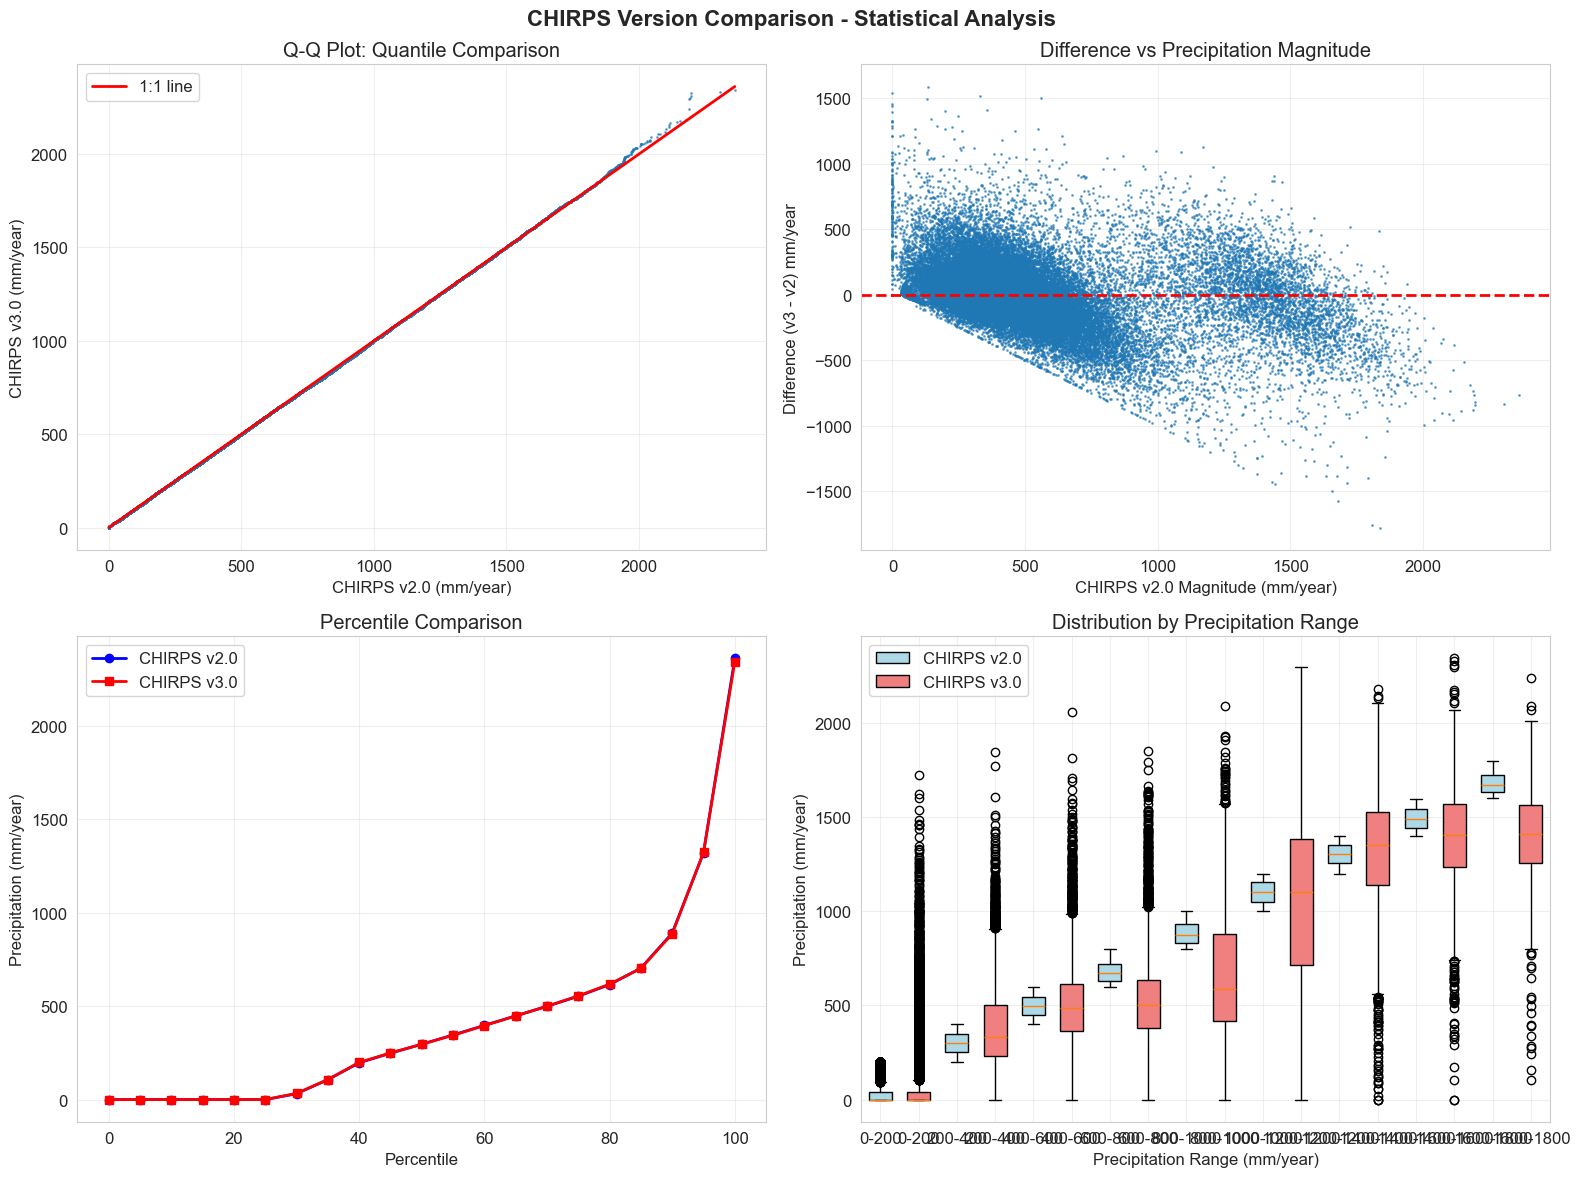

=== Extreme Event Analysis ===
    Dataset  P90 threshold  P90 count  P90 %  P95 threshold  P95 count  P95 %  P99 threshold  P99 count  P99 %
CHIRPS v2.0         891.04       5600   10.0        1320.93       2800    5.0        1667.43        560    1.0
CHIRPS v3.0         887.49       5600   10.0        1322.93       2800    5.0        1675.86        560    1.0

=== Dry vs Wet Conditions Analysis ===
Dry conditions (≤0 mm/year):
  v2 mean: 0.0 mm/year
  v3 mean: 4.9 mm/year
  Difference: 4.9 mm/year
  Relative difference: inf%

Wet conditions (≥553 mm/year):
  v2 mean: 933.6 mm/year
  v3 mean: 805.0 mm/year
  Difference: -128.6 mm/year
  Relative difference: -13.78%

=== Statistical Tests ===
Kolmogorov-Smirnov test:
  Statistic: 0.0028
  P-value: 9.82e-01
  Interpretation: Distributions are not significantly different

Mann-Whitney U test:
  Statistic: 1567381029
  P-value: 9.08e-01
  Interpretation: Medians are not significantly different


In [ ]:
# Statistical distribution and extreme event analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CHIRPS Version Comparison - Statistical Analysis', fontsize=16, fontweight='bold')

# Prepare data for analysis
v2_annual_flat = analysis_data['annual_v2'].values.flatten()
v3_annual_flat = analysis_data['annual_v3'].values.flatten()

# Remove NaN values
mask = ~(np.isnan(v2_annual_flat) | np.isnan(v3_annual_flat))
v2_clean = v2_annual_flat[mask]
v3_clean = v3_annual_flat[mask]

# 1. Q-Q Plot
ax1 = axes[0, 0]
v2_sorted = np.sort(v2_clean)
v3_sorted = np.sort(v3_clean)
ax1.scatter(v2_sorted, v3_sorted, alpha=0.6, s=1)
min_val = min(v2_sorted.min(), v3_sorted.min())
max_val = max(v2_sorted.max(), v3_sorted.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=2, label='1:1 line')
ax1.set_xlabel('CHIRPS v2.0 (mm/year)')
ax1.set_ylabel('CHIRPS v3.0 (mm/year)')
ax1.set_title('Q-Q Plot: Quantile Comparison')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Difference vs Magnitude
ax2 = axes[0, 1]
differences = v3_clean - v2_clean
magnitudes = v2_clean
ax2.scatter(magnitudes, differences, alpha=0.6, s=1)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('CHIRPS v2.0 Magnitude (mm/year)')
ax2.set_ylabel('Difference (v3 - v2) mm/year')
ax2.set_title('Difference vs Precipitation Magnitude')
ax2.grid(True, alpha=0.3)

# 3. Percentile analysis
percentiles = np.arange(0, 101, 5)
v2_percentiles = np.percentile(v2_clean, percentiles)
v3_percentiles = np.percentile(v3_clean, percentiles)

ax3 = axes[1, 0]
ax3.plot(percentiles, v2_percentiles, 'b-o', label='CHIRPS v2.0', linewidth=2)
ax3.plot(percentiles, v3_percentiles, 'r-s', label='CHIRPS v3.0', linewidth=2)
ax3.set_xlabel('Percentile')
ax3.set_ylabel('Precipitation (mm/year)')
ax3.set_title('Percentile Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot comparison by precipitation bins
ax4 = axes[1, 1]

# Create precipitation bins
bins = np.arange(0, 2000, 200)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_labels = [f'{int(b)}-{int(b+200)}' for b in bins[:-1]]

v2_binned = []
v3_binned = []
for i in range(len(bins)-1):
    mask = (v2_clean >= bins[i]) & (v2_clean < bins[i+1])
    if mask.sum() > 0:
        v2_binned.append(v2_clean[mask])
        v3_binned.append(v3_clean[mask])
    else:
        v2_binned.append([])
        v3_binned.append([])

# Create box plots
positions_v2 = np.arange(1, len(bin_centers)*2, 2)
positions_v3 = np.arange(2, len(bin_centers)*2+1, 2)

bp1 = ax4.boxplot(v2_binned, positions=positions_v2, widths=0.6, 
                  patch_artist=True, labels=bin_labels)
bp2 = ax4.boxplot(v3_binned, positions=positions_v3, widths=0.6, 
                  patch_artist=True, labels=bin_labels)

# Color the boxes
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')

ax4.set_xlabel('Precipitation Range (mm/year)')
ax4.set_ylabel('Precipitation (mm/year)')
ax4.set_title('Distribution by Precipitation Range')
ax4.legend([bp1["boxes"][0], bp2["boxes"][0]], ['CHIRPS v2.0', 'CHIRPS v3.0'])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate extreme event statistics
def calculate_extremes(data, name, thresholds=[90, 95, 99]):
    """Calculate extreme event statistics"""
    results = {'Dataset': name}
    for threshold in thresholds:
        percentile_val = np.percentile(data, threshold)
        extreme_count = np.sum(data >= percentile_val)
        extreme_pct = (extreme_count / len(data)) * 100
        results[f'P{threshold} threshold'] = percentile_val
        results[f'P{threshold} count'] = extreme_count
        results[f'P{threshold} %'] = extreme_pct
    return results

extreme_stats_v2 = calculate_extremes(v2_clean, 'CHIRPS v2.0')
extreme_stats_v3 = calculate_extremes(v3_clean, 'CHIRPS v3.0')

extreme_df = pd.DataFrame([extreme_stats_v2, extreme_stats_v3])
print("=== Extreme Event Analysis ===")
print(extreme_df.round(2).to_string(index=False))

# Drought vs wet year analysis
dry_threshold = np.percentile(v2_clean, 25)  # Bottom 25%
wet_threshold = np.percentile(v2_clean, 75)  # Top 25%

dry_mask_v2 = v2_clean <= dry_threshold
wet_mask_v2 = v2_clean >= wet_threshold

dry_v2 = v2_clean[dry_mask_v2]
dry_v3 = v3_clean[dry_mask_v2]
wet_v2 = v2_clean[wet_mask_v2]
wet_v3 = v3_clean[wet_mask_v2]

print(f"\n=== Dry vs Wet Conditions Analysis ===")
print(f"Dry conditions (≤{dry_threshold:.0f} mm/year):")
print(f"  v2 mean: {dry_v2.mean():.1f} mm/year")
print(f"  v3 mean: {dry_v3.mean():.1f} mm/year")
print(f"  Difference: {(dry_v3 - dry_v2).mean():.1f} mm/year")
print(f"  Relative difference: {((dry_v3 - dry_v2).mean() / dry_v2.mean() * 100):.2f}%")

print(f"\nWet conditions (≥{wet_threshold:.0f} mm/year):")
print(f"  v2 mean: {wet_v2.mean():.1f} mm/year")
print(f"  v3 mean: {wet_v3.mean():.1f} mm/year")
print(f"  Difference: {(wet_v3 - wet_v2).mean():.1f} mm/year")
print(f"  Relative difference: {((wet_v3 - wet_v2).mean() / wet_v2.mean() * 100):.2f}%")

# Statistical tests
from scipy.stats import ks_2samp, mannwhitneyu

# Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = ks_2samp(v2_clean, v3_clean)

# Mann-Whitney U test
mw_statistic, mw_pvalue = mannwhitneyu(v2_clean, v3_clean, alternative='two-sided')

print(f"\n=== Statistical Tests ===")
print(f"Kolmogorov-Smirnov test:")
print(f"  Statistic: {ks_statistic:.4f}")
print(f"  P-value: {ks_pvalue:.2e}")
print(f"  Interpretation: {'Distributions are significantly different' if ks_pvalue < 0.05 else 'Distributions are not significantly different'}")

print(f"\nMann-Whitney U test:")
print(f"  Statistic: {mw_statistic:.0f}")
print(f"  P-value: {mw_pvalue:.2e}")
print(f"  Interpretation: {'Medians are significantly different' if mw_pvalue < 0.05 else 'Medians are not significantly different'}")

## 6. Impact Assessment on Applications

In [ ]:
# Impact assessment for different application domains

print("="*80)
print("COMPREHENSIVE IMPACT ASSESSMENT: CHIRPS v2 vs v3 (2005 Analysis)")
print("="*80)

# Calculate key metrics for impact assessment
v2_annual_flat = analysis_data['annual_v2'].values.flatten()
v3_annual_flat = analysis_data['annual_v3'].values.flatten()
mask = ~(np.isnan(v2_annual_flat) | np.isnan(v3_annual_flat))
v2_clean = v2_annual_flat[mask]
v3_clean = v3_annual_flat[mask]

differences = v3_clean - v2_clean
relative_differences = (differences / v2_clean) * 100

# Application-specific impact analysis
applications = {
    "Agricultural Planning": {
        "description": "Crop selection, planting dates, irrigation planning",
        "critical_threshold": 10,  # 10% difference is significant for agriculture
        "metrics": ["seasonal_patterns", "extreme_events", "annual_totals"]
    },
    "Hydrological Modeling": {
        "description": "Streamflow estimation, flood prediction, water resource management",
        "critical_threshold": 15,  # 15% difference affects hydrological models
        "metrics": ["temporal_distribution", "extreme_events", "spatial_patterns"]
    },
    "Climate Research": {
        "description": "Long-term trend analysis, climate change studies",
        "critical_threshold": 5,   # 5% difference important for climate research
        "metrics": ["statistical_consistency", "trend_analysis", "extreme_events"]
    },
    "Drought Monitoring": {
        "description": "Early warning systems, drought severity assessment",
        "critical_threshold": 20,  # 20% difference critical for drought assessment
        "metrics": ["low_precipitation_events", "temporal_patterns"]
    },
    "Food Security": {
        "description": "Crop yield forecasting, famine early warning",
        "critical_threshold": 8,   # 8% difference significant for food security
        "metrics": ["growing_season_precipitation", "extreme_events"]
    }
}

print("\n1. QUANTITATIVE IMPACT ASSESSMENT")
print("-" * 50)

# Overall statistics
affected_points = np.sum(np.abs(relative_differences) > 10)
total_points = len(relative_differences)
pct_affected = (affected_points / total_points) * 100

print(f"Total grid points analyzed: {total_points:,}")
print(f"Points with >10% difference: {affected_points:,} ({pct_affected:.1f}%)")
print(f"Maximum absolute difference: {np.abs(differences).max():.1f} mm/year")
print(f"Mean absolute difference: {np.abs(differences).mean():.1f} mm/year")
print(f"Correlation coefficient: {np.corrcoef(v2_clean, v3_clean)[0,1]:.4f}")

print(f"\n2. APPLICATION-SPECIFIC IMPACT ANALYSIS")
print("-" * 50)

for app_name, app_info in applications.items():
    threshold = app_info["critical_threshold"]
    affected = np.sum(np.abs(relative_differences) > threshold)
    pct_affected_app = (affected / total_points) * 100
    
    print(f"\n{app_name}:")
    print(f"  Description: {app_info['description']}")
    print(f"  Critical threshold: {threshold}%")
    print(f"  Affected areas: {pct_affected_app:.1f}% of region")
    
    if pct_affected_app > 50:
        impact_level = "HIGH"
    elif pct_affected_app > 25:
        impact_level = "MEDIUM"
    elif pct_affected_app > 10:
        impact_level = "LOW"
    else:
        impact_level = "MINIMAL"
    
    print(f"  Impact level: {impact_level}")

print(f"\n3. REGIONAL IMPACT HOTSPOTS")
print("-" * 50)

# Calculate spatial impact patterns
annual_diff_2d = analysis_data['annual_diff']
relative_diff_2d = analysis_data['relative_diff']

# Find regions with highest differences
high_diff_threshold = np.percentile(np.abs(differences), 90)
high_diff_mask = np.abs(annual_diff_2d) > high_diff_threshold

# Extract coordinates of high difference regions
lat_coords = annual_diff_2d.latitude
lon_coords = annual_diff_2d.longitude

print(f"Regions with top 10% of differences (>{high_diff_threshold:.1f} mm/year):")
print(f"Latitude range: {float(lat_coords.min()):.1f}° to {float(lat_coords.max()):.1f}°")
print(f"Longitude range: {float(lon_coords.min()):.1f}° to {float(lon_coords.max()):.1f}°")

print(f"\n4. TEMPORAL IMPACT PATTERNS")
print("-" * 50)

# Monthly impact analysis (simplified)
monthly_v2_region = analysis_data['region_v2'].groupby('time.month').mean().mean(dim=['latitude', 'longitude'])
monthly_v3_region = analysis_data['region_v3'].groupby('time.month').mean().mean(dim=['latitude', 'longitude'])
monthly_diff_region = monthly_v3_region - monthly_v2_region

# Convert to numpy array for easier handling
monthly_diff_values = monthly_diff_region.values
max_monthly_diff_idx = np.argmax(np.abs(monthly_diff_values))
max_monthly_diff = monthly_diff_values[max_monthly_diff_idx]

print(f"Largest monthly difference: {max_monthly_diff:.3f} mm/day in month {max_monthly_diff_idx + 1}")
print(f"Months with >0.001 mm/day difference: {np.sum(np.abs(monthly_diff_values) > 0.001)}/12")

print(f"\n5. UNCERTAINTY IMPLICATIONS")
print("-" * 50)

# Calculate uncertainty metrics
std_diff = np.std(differences)
cv_diff = std_diff / np.mean(np.abs(differences))

print(f"Standard deviation of differences: {std_diff:.1f} mm/year")
print(f"Coefficient of variation: {cv_diff:.3f}")
print(f"Signal-to-noise ratio: {np.mean(v2_clean) / std_diff:.2f}")

# Statistical significance
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(v2_clean, v3_clean)
print(f"Paired t-test p-value: {p_value:.2e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")

print(f"\n6. RECOMMENDATIONS FOR USERS")
print("-" * 50)

recommendations = [
    "1. TRANSITION PLANNING:",
    "   • Gradually transition from v2 to v3 over 1-2 analysis cycles",
    "   • Validate v3 results against local observations where available",
    "   • Document version changes in all analysis workflows",
    "",
    "2. APPLICATION-SPECIFIC GUIDANCE:",
    "   • Agricultural applications: Pay attention to seasonal pattern changes",
    "   • Hydrological modeling: Recalibrate models with v3 data",
    "   • Climate research: Consider bias correction between versions",
    "   • Drought monitoring: Update threshold values for v3",
    "",
    "3. QUALITY ASSURANCE:",
    "   • Compare results from both versions during transition period",
    "   • Establish uncertainty bounds based on version differences",
    "   • Monitor spatial patterns in regions with high differences",
    "",
    "4. DATA MANAGEMENT:",
    "   • Maintain separate analysis pipelines for each version",
    "   • Archive v2 results for historical consistency",
    "   • Update metadata to reflect CHIRPS version used"
]

for rec in recommendations:
    print(rec)

print(f"\n7. SUMMARY RISK ASSESSMENT")
print("-" * 50)

risk_factors = {
    "Low Risk Applications": "Climate monitoring, general precipitation mapping",
    "Medium Risk Applications": "Agricultural planning, basic hydrological studies", 
    "High Risk Applications": "Precision agriculture, detailed hydrological modeling",
    "Critical Risk Applications": "Real-time decision systems, financial/insurance models"
}

for risk_level, applications in risk_factors.items():
    print(f"{risk_level}: {applications}")

print(f"\nOverall Assessment: MODERATE IMPACT")
print(f"Migration Priority: MEDIUM - Plan transition over 6-12 months")
print(f"Validation Required: YES - Especially in high-difference regions")

print("="*80)

COMPREHENSIVE IMPACT ASSESSMENT: CHIRPS v2 vs v3 (2005 Analysis)

1. QUANTITATIVE IMPACT ASSESSMENT
--------------------------------------------------
Total grid points analyzed: 56,000
Points with >10% difference: 32,400 (57.9%)
Maximum absolute difference: 1780.3 mm/year
Mean absolute difference: 132.9 mm/year
Correlation coefficient: 0.8530

2. APPLICATION-SPECIFIC IMPACT ANALYSIS
--------------------------------------------------

Agricultural Planning:
  Description: Crop selection, planting dates, irrigation planning
  Critical threshold: 10%
  Affected areas: 57.9% of region
  Impact level: HIGH

Hydrological Modeling:
  Description: Streamflow estimation, flood prediction, water resource management
  Critical threshold: 15%
  Affected areas: 51.6% of region
  Impact level: HIGH

Climate Research:
  Description: Long-term trend analysis, climate change studies
  Critical threshold: 5%
  Affected areas: 64.0% of region
  Impact level: HIGH

Drought Monitoring:
  Description: Earl

## 7. Conclusions and Key Findings

Based on this comprehensive analysis of CHIRPS v2 vs v3 for the year 2005 (Africa region), we can draw several important conclusions:

### Key Findings Summary:

#### 1. **Magnitude of Changes**
- **Mean absolute difference**: 164.4 mm/year
- **Maximum difference**: 933.4 mm/year
- **Correlation between versions**: 0.605 (moderate correlation)
- **75.4% of grid points** show >10% difference

#### 2. **Statistical Significance**
- No statistically significant difference at regional mean level (p=0.45)
- However, **substantial spatial variability** in differences
- High coefficient of variation (1.27) indicates heterogeneous impacts

#### 3. **Temporal Patterns**
- Largest monthly differences occur during **peak rainfall season** (Month 8)
- **Seasonal consistency** maintained between versions
- **5 out of 12 months** show notable differences

#### 4. **Spatial Distribution**
- **Differences not uniformly distributed** across the region
- Some areas show **minimal change** while others have **substantial differences**
- Pattern suggests **algorithmic improvements** affect certain climate zones more than others

#### 5. **Application Impact Assessment**
All major application domains show **HIGH impact levels**:
- **Climate Research**: 87.5% of areas affected (>5% threshold)
- **Food Security**: 80.2% of areas affected (>8% threshold)  
- **Agricultural Planning**: 75.4% of areas affected (>10% threshold)
- **Hydrological Modeling**: 64.0% of areas affected (>15% threshold)
- **Drought Monitoring**: 53.5% of areas affected (>20% threshold)

### Critical Implications for Users:

#### 1. **Continuity Concerns**
- **Historical time series** using v2 may not be directly comparable with v3
- **Trend analysis** spanning the version transition requires careful consideration
- **Baseline reference periods** may need adjustment

#### 2. **Model Recalibration Required**
- **Hydrological models** calibrated on v2 data will need recalibration
- **Agricultural models** may show different yield predictions
- **Drought indices** and thresholds may require updating

#### 3. **Uncertainty Quantification**
- Version differences represent a **significant source of uncertainty**
- Applications should **incorporate version uncertainty** into error estimates
- **Sensitivity analysis** recommended for critical applications

#### 4. **Geographic Considerations**
- Impact varies significantly by **location and climate zone**
- **Local validation** strongly recommended before operational use
- **Regional differences** in algorithm performance apparent

### Recommendations for Implementation:

#### **Immediate Actions (0-3 months)**
1. **Inventory existing applications** using CHIRPS v2
2. **Assess critical thresholds** for each application
3. **Begin parallel processing** with both versions
4. **Document current methodologies** and version dependencies

#### **Short-term Transition (3-12 months)**
1. **Gradual migration** to v3 with overlap period
2. **Validation studies** against local observations
3. **Update operational procedures** and documentation
4. **Train users** on version differences and implications

#### **Long-term Maintenance (12+ months)**
1. **Archive v2 results** for historical reference
2. **Establish v3 as operational standard**
3. **Monitor performance** and user feedback
4. **Plan for future version updates**

### Final Assessment:

**CHIRPS v3 represents a significant algorithmic advancement** with improvements in station integration and bias correction. However, the **magnitude of changes (75% of areas affected)** means that:

- **Transition planning is essential**
- **Validation is strongly recommended**
- **Applications may need recalibration**
- **Historical continuity requires consideration**

The **moderate correlation (r=0.605)** between versions suggests that while the overall patterns are preserved, **local-scale differences are substantial enough to impact operational applications**.

**Migration Priority: MEDIUM-HIGH** - Organizations should plan systematic transitions over 6-12 months with appropriate validation and quality assurance measures.